# Alex Parson
# Ronak Goyal
# Pranav Garg
# Sneha Sastry Rayadurgam

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
from PIL import Image


def create_neighbor_similarity_network_work(arr, sigma):
    rows, cols = arr.shape
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c), intensity=arr[r, c])

    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    epsilon = 1e-6  # Small constant to prevent zero capacities

    for r in range(rows):
        for c in range(cols):
            for dr, dc in neighbors:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols:
                    I_i = arr[r, c]
                    I_j = arr[nr, nc]
                    similarity = 100 * np.exp(-((I_i - I_j) ** 2) / (2 * sigma ** 2)) + epsilon
                    G.add_edge((r, c), (nr, nc), capacity=similarity)

    # Manually specify source and sink nodes
    min_pixel = np.unravel_index(np.argmin(arr), arr.shape) # Replace with appropriate coordinates
    max_pixel = np.unravel_index(np.argmax(arr), arr.shape)      # Replace with appropriate coordinates

    source_node = 'source'
    sink_node = 'sink'
    G.add_node(source_node)
    G.add_node(sink_node)

    G.add_edge(source_node, min_pixel, capacity=100)
    G.add_edge(max_pixel, sink_node, capacity=100)

    return G, source_node, sink_node

def create_neighbor_similarity_network(arr, sigma, bx, by, fx, fy):
    rows, cols = arr.shape
    G = nx.Graph()

    for r in range(rows):
        for c in range(cols):
            G.add_node((r, c), intensity=arr[r, c])

    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    epsilon = 1e-6  # Small constant to prevent zero capacities

    for r in range(rows):
        for c in range(cols):
            for dr, dc in neighbors:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols:
                    I_i = arr[r, c]
                    I_j = arr[nr, nc]
                    similarity = 100 * np.exp(-((I_i - I_j) ** 2) / (2 * sigma ** 2)) + epsilon
                    G.add_edge((r, c), (nr, nc), capacity=similarity)

    # Manually specify source and sink nodes
    if (bx is None) and (by == None) and (fx is None) and (fy == None):
        min_pixel = np.unravel_index(np.argmin(arr), arr.shape) # Replace with appropriate coordinates
        max_pixel = np.unravel_index(np.argmax(arr), arr.shape)      # Replace with appropriate coordinates
        print(f"Background pixel index: {min_pixel}")
        print(f"Foreground pixel index: {max_pixel}")
    else:
        min_pixel = (bx, by)
        max_pixel = (fx, fy)
        print(f"Background pixel index: {min_pixel}")
        print(f"Foreground pixel index: {max_pixel}")

    source_node = 'source'
    sink_node = 'sink'
    G.add_node(source_node)
    G.add_node(sink_node)

    G.add_edge(source_node, min_pixel, capacity=100)
    G.add_edge(max_pixel, sink_node, capacity=100)

    return G, source_node, sink_node

# Rest of the code remains the same...
def load_data(file_path):
    if file_path.endswith('.csv'):
        # Load CSV file as intensity matrix and convert to NumPy array
        intensity_matrix = np.loadtxt(file_path, delimiter=',')
        print('its a csv')
    else:
        image = Image.open(file_path).convert('L')
        print('its an image')
        intensity_matrix = np.array(image)
        intensity_matrix = (intensity_matrix / 255.0) * 100
    
    return intensity_matrix

def solve_max_flow_undirected(G, source, sink):
    DG = G.to_directed()
    m = gp.Model()
    m.Params.LogToConsole = 0

    flow = m.addVars(G.edges(), lb=0, ub={(u, v): DG[u][v]['capacity'] for u, v in DG.edges()}, name="flow")

    for u, v in G.edges():
        capacity = G[u][v]['capacity']
        m.addConstr(flow[u, v] <= capacity, name=f"cap_{u}_{v}_pos")
        m.addConstr(-flow[u, v] <= capacity, name=f"cap_{u}_{v}_neg")

    net_flow = gp.quicksum(flow[source, neighbor] for neighbor in G.neighbors(source) if (source, neighbor) in flow)
    net_flow -= gp.quicksum(flow[neighbor, source] for neighbor in G.neighbors(source) if (neighbor, source) in flow)
    m.setObjective(net_flow, GRB.MAXIMIZE)

    for node in G.nodes():
        if node == source or node == sink:
            continue
        inflow = gp.quicksum(flow[neighbor, node] for neighbor in G.neighbors(node) if (neighbor, node) in flow)
        outflow = gp.quicksum(flow[node, neighbor] for neighbor in G.neighbors(node) if (node, neighbor) in flow)
        m.addConstr(inflow - outflow == 0, name=f"flow_conservation_{node}")

    m.optimize()

    return m, flow

def build_residual_network_undirected(G, flow_values):
    residual_G = nx.Graph()
    for u, v in G.edges():
        capacity = G[u][v]['capacity']
        flow_uv = flow_values[u, v]

        residual_capacity_uv = capacity - max(flow_uv, 0)
        residual_capacity_vu = capacity + min(flow_uv, 0)

        if residual_capacity_uv > 1e-6:
            residual_G.add_edge(u, v, capacity=residual_capacity_uv)
        if residual_capacity_vu > 1e-6:
            residual_G.add_edge(v, u, capacity=residual_capacity_vu)
    return residual_G

def get_accessible_nodes(residual_G, source):
    visited = set()
    stack = [source]
    while stack:
        node = stack.pop()
        if node not in visited:
            visited.add(node)
            for neighbor in residual_G.neighbors(node):
                if neighbor not in visited:
                    stack.append(neighbor)
    return visited

def get_min_cut_edges_undirected(G, accessible_nodes):
    cut_edges = []
    for u in accessible_nodes:
        for v in G.neighbors(u):
            if v not in accessible_nodes:
                cut_edges.append((u, v))
    return cut_edges

def plot_cuts_on_image(arr, cut_edges):
    plt.figure(figsize=(4, 4))
    plt.imshow(arr, cmap='gray', interpolation='none')
    ax = plt.gca()
    for u, v in cut_edges:
        if isinstance(u, tuple) and isinstance(v, tuple):
            y1, x1 = u
            y2, x2 = v

            if y1 == y2:
                # Horizontal neighbors, vertical cut between them
                x_cut = (x1 + x2) / 2
                y_cut_start = y1 - 0.5
                y_cut_end = y1 + 0.5
                ax.plot([x_cut, x_cut], [y_cut_start, y_cut_end], color='red', linewidth=1.5)
            elif x1 == x2:
                # Vertical neighbors, horizontal cut between them
                y_cut = (y1 + y2) / 2
                x_cut_start = x1 - 0.5
                x_cut_end = x1 + 0.5
                ax.plot([x_cut_start, x_cut_end], [y_cut, y_cut], color='red', linewidth=1.5)
    plt.title('Min-Cut Edges')
    #plt.gca().invert_yaxis()
    plt.show()

# Main script
def main(file_path, bx=None, by=None, fx=None, fy=None, sig=10):

    # # Get inputs from the user
    # file_path = input("Enter the file path (CSV or Image): ")
    # bx = int(input("Enter x coordinate of background pixel: "))
    # by = int(input("Enter y coordinate of background pixel: "))
    # fx = int(input("Enter x coordinate of foreground pixel: "))
    # fy = int(input("Enter y coordinate of foreground pixel: "))
    # sig = float(input("Enter sigma value (controls pixel similarity): "))

    # Step 1: Read the JPEG image and convert it to grayscale
    arr = load_data(file_path)
    
    # Step 2: Proceed with the rest of the code
    sigma = sig  # Adjust sigma as needed for your image
    print(f"Sigma value: {sigma}")

    G, source_node, sink_node = create_neighbor_similarity_network(arr, sigma, bx, by, fx, fy)

    m, flow = solve_max_flow_undirected(G, source_node, sink_node)

    if m.status == GRB.OPTIMAL:
        flow_values = m.getAttr('x', flow)
        residual_G = build_residual_network_undirected(G, flow_values)
        accessible_nodes = get_accessible_nodes(residual_G, source_node)
        cut_edges = get_min_cut_edges_undirected(G, accessible_nodes)
        plot_cuts_on_image(arr, cut_edges)
    else:
        print("Optimal solution was not found.")


In [2]:
def user_input():
    file_path = input("Please enter file path")
    bx = input("Please enter x co-ordinate of background pixel")
    by = input("Please enter y co-ordinate of background pixel")
    fx = input("Please enter x co-ordinate of the foregorund pixel")
    fy = input("Please enter y co-ordinate of the foregound pixel")
    sigma = input("Please enter the sigma value (controls pixel similarity)")
    if bx=='':
        bx=None
    else:
        bx=int(bx)
    if by=='':
        by=None
    else:
        by=int(by)
    if fx=='':
        fx=None
    else:
        fx=int(fx)
    if fy=='':
        fy=None
    else:
        fy=int(fy)
    if sigma=='':
        sigma = 0.05
    else:
        sigma = float(sigma)
    return file_path,bx,by,fx,fy,sigma

its an image
Sigma value: 0.8
Background pixel index: (48, 65)
Foreground pixel index: (51, 82)
Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-26


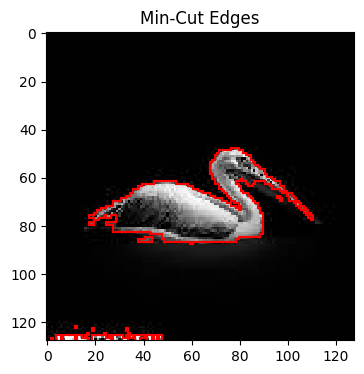

In [3]:
file_path,bx,by,fx,fy,sigma = user_input()
main(file_path,bx,by,fx,fy,sigma)

its a csv
Sigma value: 0.004
Background pixel index: (0, 0)
Foreground pixel index: (19, 19)


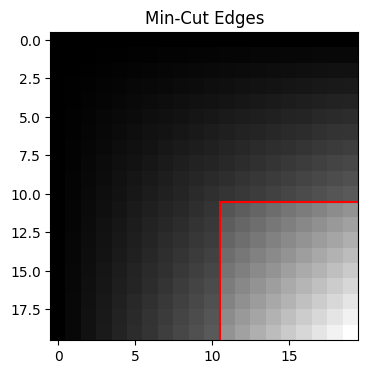

its a csv
Sigma value: 0.006
Background pixel index: (0, 0)
Foreground pixel index: (10, 10)


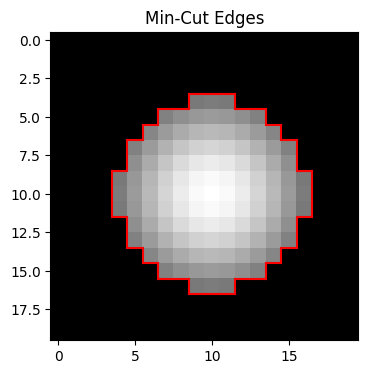

its an image
Sigma value: 0.8
Background pixel index: (48, 65)
Foreground pixel index: (51, 82)


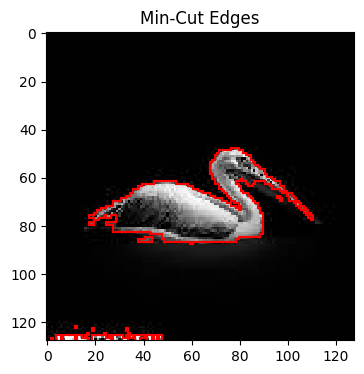

its an image
Sigma value: 0.5
Background pixel index: (0, 0)
Foreground pixel index: (89, 67)


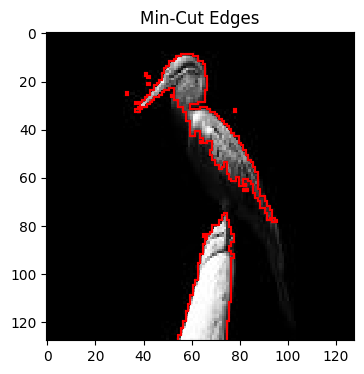

its an image
Sigma value: 1
Background pixel index: (41, 58)
Foreground pixel index: (48, 64)


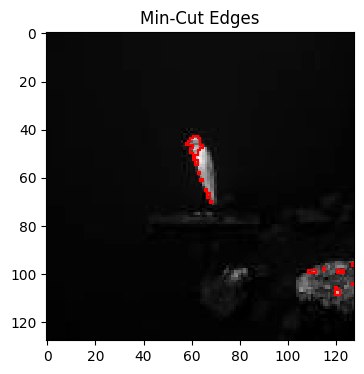

its an image
Sigma value: 1.8
Background pixel index: (47, 55)
Foreground pixel index: (19, 0)


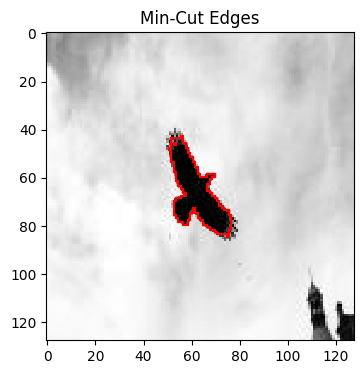

its an image
Sigma value: 0.65
Background pixel index: (44, 25)
Foreground pixel index: (15, 31)


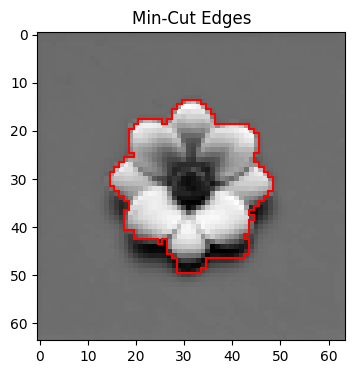

its an image
Sigma value: 0.81
Background pixel index: (83, 89)
Foreground pixel index: (114, 165)


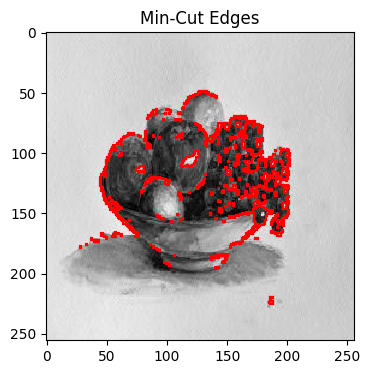

its an image
Sigma value: 0.1
Background pixel index: (0, 0)
Foreground pixel index: (61, 52)


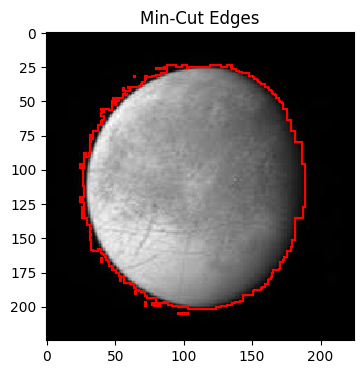

its an image
Sigma value: 0.8
Background pixel index: (0, 0)
Foreground pixel index: (39, 77)


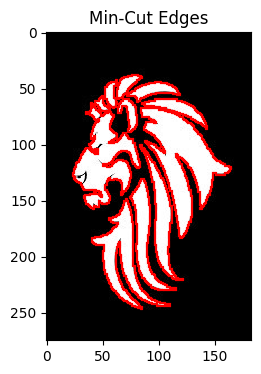

its an image
Sigma value: 1.455
Background pixel index: (39, 107)
Foreground pixel index: (36, 109)


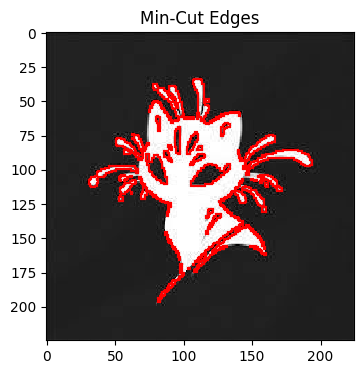

its an image
Sigma value: 2.7
Background pixel index: (59, 49)
Foreground pixel index: (35, 155)


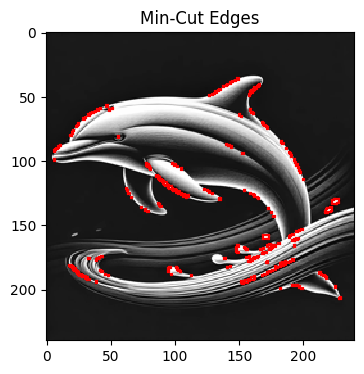

In [4]:
main(file_path='box.csv', sig=0.004)
main(file_path='oval.csv',sig=0.006)
main(file_path='img/swan.jpg', sig=0.8)
main(file_path='img/bird2_down.jpg',sig=0.5)
main(file_path='img/bird3_down.jpg',sig=1)
main(file_path='img/bird4_down.jpg',sig=1.8)
main(file_path='img/flower.png',sig=0.65)
main(file_path='img/fruit.jpg',sig=0.81) 
main(file_path='img/moon.jpg',sig=0.1)  
main(file_path='img/lion1.jpg',sig=0.8) 
main(file_path='img/cat.jpg',sig=1.455)  
main(file_path='img/dolphine.png',sig=2.7)

# for i in np.arange(2.7, 6, 0.05):
#     main('img/dolphine.png',sig=i)  